In [32]:
import os
import sys
import math
import random
import pickle
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatches

sys.path.append(os.getcwd()+'/assistive_functions')
sys.path.append(os.getcwd()+'/output')
from household import Household


from sklearn.metrics import r2_score
from sklearn.feature_selection import RFECV

import statsmodels.api as sm
import statsmodels.tsa.stattools as sttools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from SMWrapper import SMWrapper
from feat_selection import tune_num_high_corr, remove_nonsig, rfecv_selection
from construct_dataset import construct_dataset, split
from load_data import get_data_of_a_person, get_data_of_acorn_group, get_data_of_mixed_group
from analyze_model import plot_actual_prediction, error_measures, residuals_plot, monthly_plots


random.seed(30)
np.random.seed(30)

# 0 Introduction
**0.1 Goal**
* 1 step-ahead electricity consumption prediction
* single house
* consider weahter and calendar effects

**0.2 Data**
* random household in London
* January 2012 to December 2013
* 30 min resolution
* hourly temperature records
* date and time information

**0.3 Recap of Visualization and Data Analya**
* Plots of Holiday vs. weekday vs. weekend: widely varrying patterns
* Time-series plots: data has sharp peaks
* Box plots vs. time and temperature: the occurance of these peaks has no visible pattern, and are diagnosed as outliers 
* Auto-correlation and partial auto-correlation: auto-regressors with lags in 48k+/-3, k between 0 to 7 are informative
* seasonal differences cannot be easily detected


**0.4 Summary**
* Need different models for weekday/weekend/holiday
* Predicting the peaks can be challenging or impossible
* AR models with lagged versions of the time-series as features are suitable for the task

**0.5 In This Notebook**
* One-step-ahead consumption prediction of a fixed household
* Feature selection problem: determining suitable auto-regressors 
* Evaluating fit results
* Studying the effect of day part (morning/noon/...) on prediction error

**0.6 General Setup**
* Single fixed household
* Only Thursdays that were not a holiday (see section 1)
* Dependent variable (target): one-step-ahead consumption
* Regressors (features): constant / hour of day (x,y) / day of year (x,y) / temperature / auto-regressors(delayed versions)
* The same model is used for all parts of Tuesdays (morning/noon/...) and all seasons

**Setup is the same in all sections unless specified**
**  **

# 1 Preparing The Data for Regression

**1.1 Cleaning**
* interpolate missing values
* merge consumption, weather, and calendar data to a single dataframe
* no outlier removal method 
* convert time of day and day of year to x,y
* min-max scaling to [-1, 1]

**1.2 Filtering the data**
* fix one day, e.g. Thursday
* remove all holidays

**1.2 Constructing regression dataframe**
* dependent variable: consumption at time interval t
* regressors: temperature, time of day (x,y), day of year (x,y), auto-regressors(delayed versions of the signal)
* dealing with holidays: if holidays appear among auto-regressors, replace them with the previous day. If the previous day is weekend, holiday, or already in the features, keep going 1 day back.

**1.3 Describing the options**
* filt_days: the day of week for which we are training a model
* remove_holiday, replacement_method: if public holidays should be removed, b.c. they are different from normal days, and how to replace them (default: True, week_before)
* feat_cols: which temporal features are used in the regression dataframe
* dayparts: can select different parts of day to fit a specific model for them, e.g. only for nights (default is [] for selecting the whole day)
* lags: autoregressive features to be used
* step_ahead: prediction horizon, e.g. if step_ahead=1 predicts the next time step (30 min) using data up to now, if step_ahead=2 predicts 2 steps into future (1 hour) using data up to now, ...

In [19]:
# set options
step_ahead=1

# candidate lags
lags = []
for i in np.arange(8):
    lags = lags + [48*i+1,48*i+2,48*i+3,48*i+48]
lags = [x-step_ahead+1 for x in lags if x>=step_ahead]

# regression options
options = {"filt_days":['Tuesday'], 
           "remove_holiday":True,
           "resolution":30,
           "feat_cols":['hourofd_x', 'hourofd_y', 'dayofy_x', 'dayofy_y', 'temperature_hourly'],
           "replacement_method":'week_before',
           "dayparts":[]}

In [20]:
# construct household obj
block=77
house_id = "MAC000068"
household = Household(house_id=house_id, block_num=block)
# load data with regression options
has_data = household.load_data()
if not has_data:
    print('no data')
household.construct_dataset(lags=lags, step_ahead=step_ahead, options=options)
df_1p = household.cons_data

In [21]:
# print information about this household
path = os.getcwd()+"/input/informations_households.csv.xls"
data = pd.read_csv(path)
info = data.loc[data.LCLid==household.house_id]
print(info)

          LCLid stdorToU    Acorn Acorn_grouped      file
3871  MAC000068      Std  ACORN-L     Adversity  block_77


# 2 Feature Selection
**2.0 Theory**
* Question: which delays of the signal should be in the regressors?

* Feature selection problem: finding the most appropriate set of regressors, in this problem, delayed versions

* More regressors (features) maximize the explanatory power of our model, but could increase variance in the prediction

* The fit improves after feature reduction if MSE associated with parameter estimates will be smaller than the reduction in variance

**Methods**

* Regressors that are highly correlated with the dependent variable: univariate test, filtering is based on an arbitrary threshold or manually fixed number of regressors, or tuned by cross-validation 

* Recursive feature elimination (RFE): start with all regressors, recursively remove less important regressors, repeat until a desired set of features remain.  

* RFECV: RFE + tune number of features with CV

* Lasso: reduces several coefficients to zero leaving only features that are truly important, by adding L1 penalty to training objective (MSE)

**Evaluation metrics**
* Different number of regressors selection methods lead to different models, need to evaluate and compare them

* MSE

* R-squared: proportion of variation in the outcome explained by regressors (the same as the squared correlation between actual and predicted values for OLS)

* Adj. R-squared: adjusted with the number of features, adjusted R-squared is equal to 1 - (n-1)/(n–k-1)*(1-R2)
               
* AIC = -2log(likelihood) + 2*number of features 

**Notes**
* For a fixed number of regressors, all methods obtain the same set of selected features 

* Selection based on correlation + tuning number of features with CV is presented in the following

* In this problem, sum of squared errors is small and AIC is monotonically increasing with the number of features. Hence, AIC is not used for comparing models.

* Adj. R2 and MSE are used as evaluation metrics


** ** 

**2.1 Method 1: highly correlated features**
* Plot auto-correlation and partial auto-correlation (PACF)

* Select highest picks in PACF 

* Number of selected regressors is tuned by CV

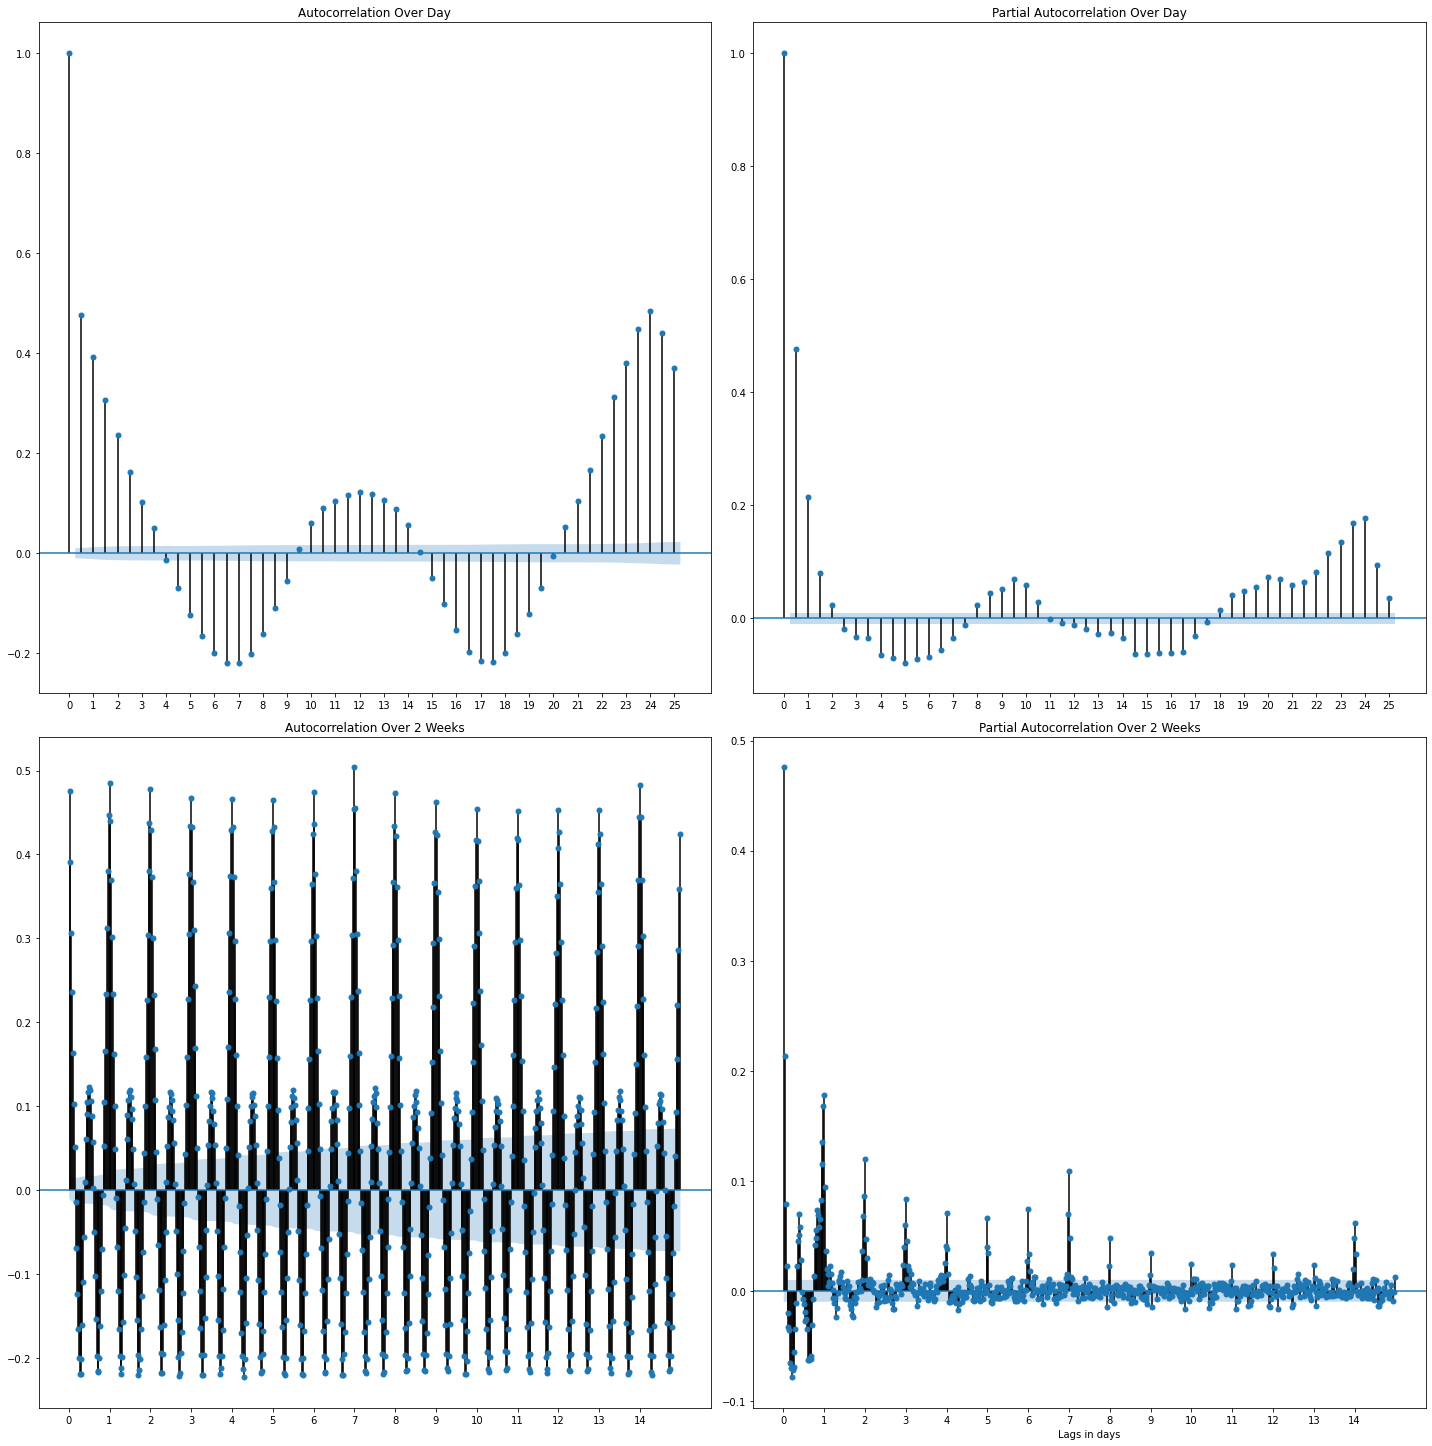

Top 20 lags in order of PACF:
[  1   2  48  47  46  96  45 336  49  95 144  44   3 288  40 192  19 335
  41  94]


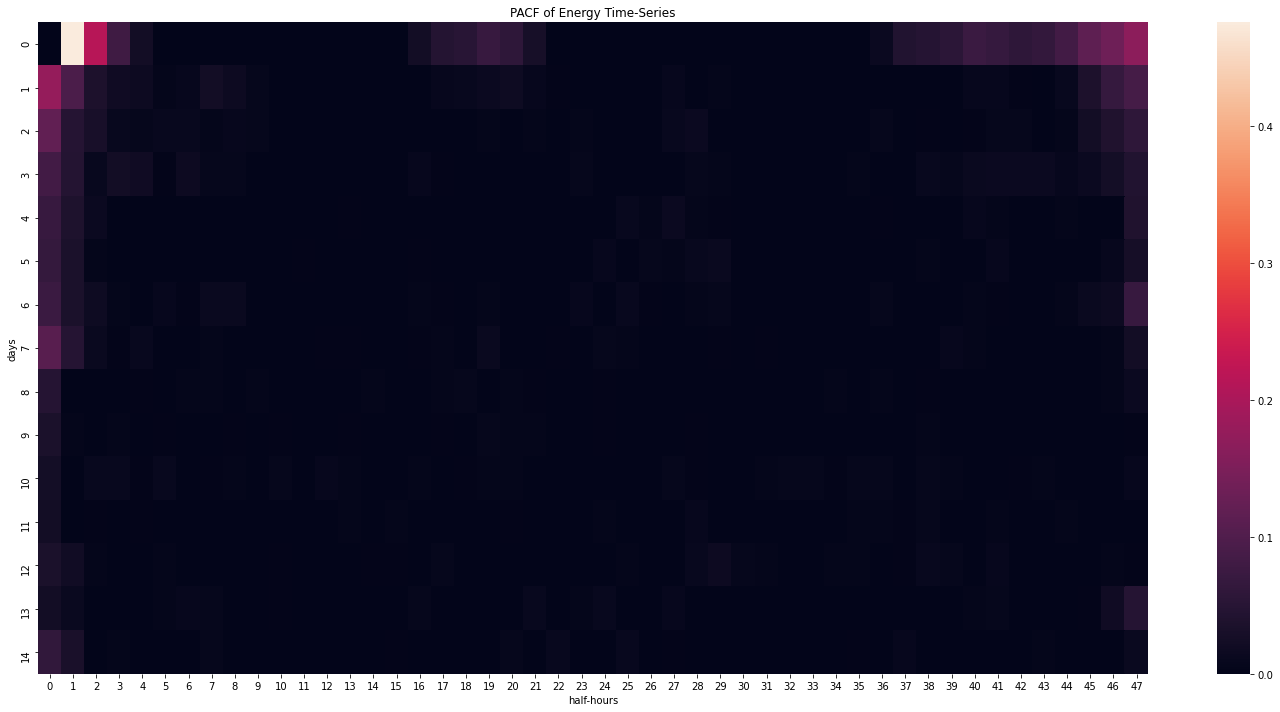

In [31]:
run_cell = True
if run_cell:
    fig, axs = plt.subplots(2, 2, figsize=(20,20))
    # Autocorrelation over day
    plot_acf(df_1p.energy, lags=25*2, ax=axs[0,0], title='Autocorrelation Over Day')
    plot_pacf(df_1p.energy, lags=25*2, ax=axs[0,1], title='Partial Autocorrelation Over Day')
    axs[0,0].set_xticks(np.arange(26)*2)
    axs[0,0].set_xticklabels(np.arange(26))
    axs[0,1].set_xticks(np.arange(26)*2)
    axs[0,1].set_xticklabels(np.arange(26))

    # over 2 weeks
    n_days=15
    lags = np.arange(1, 24*n_days*2)
    plot_acf(df_1p.energy, lags=lags, ax=axs[1,0], title='Autocorrelation Over 2 Weeks')
    plot_pacf(df_1p.energy, lags=lags, ax=axs[1,1], title='Partial Autocorrelation Over 2 Weeks')
    axs[1,0].set_xticks(np.arange(n_days)*48)
    axs[1,0].set_xticklabels(np.arange(n_days))
    axs[1,1].set_xticks(np.arange(n_days)*48)
    axs[1,1].set_xticklabels(np.arange(n_days))

    plt.tight_layout()
    plt.xlabel('Lags in days')
    plt.show()

    pacf_val = sttools.pacf(df_1p.energy, nlags=n_days*48-1)
    sorted_lags = np.argsort(-pacf_val)
    num = 20
    print('Top ' + str(num)+' lags in order of PACF:')
    print(sorted_lags[1:num+1])

    pacf_mat = [[0 for x in range(48)] for y in range(n_days)]
    for d in np.arange(n_days):
        for h in np.arange(48):
            pacf_mat[d][h]=pacf_val[d*48+h]
    pacf_mat[0][0]=0        
    # plot
    #sns.set_theme()
    fig, ax = plt.subplots(figsize=(20,10))
    sns.heatmap(pacf_mat, vmin=0, ax=ax)
    ax.set_title("PACF of Energy Time-Series")
    ax.set_xlabel('half-hours')
    ax.set_ylabel('days')
    fig.tight_layout()
    plt.show()

**Tune number of highly correlated auto-regressors**
* Other features, hourofday(x,y)/dayofyear(x,y)/temperature, are included in all models
* Lags are sorted based on their PACF
* Number of auto-regressors is increased from 1 up to 80
* Error measures are calculated
* Selected number of features = first point with test MSE <= 1.1 * min test MSE and test adj. R2 >= 0.95 * max test adj. R2

In [ ]:
run_cell = True
max_num_days=15
if run_cell:
    best, pacf_val = tune_num_high_corr(df_1p, max_num_feats=80, max_num_days=max_num_days, 
                              feat_cols=feat_cols, filt_days=filt_days, replacement_method=replacement_method,
                              repeats=10)
if not run_cell:
    pacf_val = sttools.pacf(df_1p.energy, nlags=max_num_days*48)

![<caption>](num_feat.png)

Calculating error measures for the selected number of features

In [7]:
# Method 1: highly correlated features 
best=14
sorted_lags = np.argsort(-pacf_val)
lags = np.sort(sorted_lags[1:best+1])
print('Using lags:')
print(lags)
df_reg_hc, X_hc, y_hc, feat_names_hc = construct_dataset(df_1p,
                                         feat_cols=feat_cols,
                                         filt_days = filt_days,
                                         remove_holiday=True,
                                         lags = lags,
                                         replacement_method=replacement_method)
ols_obj_hc = SMWrapper(sm.OLS).cv_fit(X_hc, y_hc)
meas_hc = error_measures(ols_obj_hc, X=X_hc, y=y_hc, verbose=True)
#print(ols_obj.summary(xname=['constant']+feat_names))

Using lags:
[  1   2   3  44  45  46  47  48  49  95  96 144 192 336]
Train R2 scores: 0.46956419514991155, 0.4692392758258581, 0.47451757445502407, 0.47657609466632755, 0.46408008405380774
Test  R2 scores: 0.46960505299833977, 0.47184579589918574, 0.44681446970151684, 0.44324314716579116, 0.4915172366842526
Mean absolute error: train 0.32, test 0.33
Mean squared error:  train 0.21, test 0.21
Explained Variance Score (best=1): train 0.46, test 0.49
Coefficient of determination (R2): train 0.46, test 0.49
Adjusted coeff. of determination:  train 0.46, test 0.49
AIC: train 24.57, test 27.34


** **
**2.2 Method 2: RFE+CV**
* Decide on importance of regressors based on t-statistic
* Compare models using adjusted R2
* Search among 14 days ago (maximum 15x48-1 features)

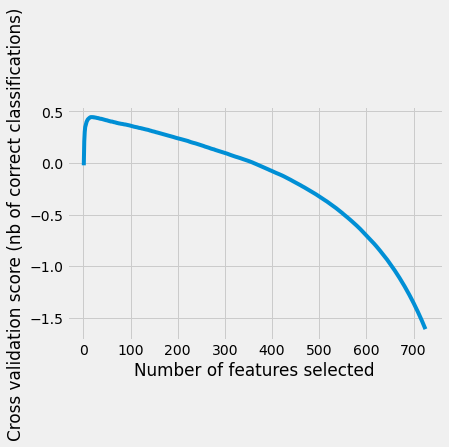


Recurssive Feature Elimination + CV
Optimal number of features: 17
Selected features:
['constant', 'hourofd_y', 'temperature_hourly', 'lag 1', 'lag 48', 'lag 96', 'lag 143', 'lag 144', 'lag 159', 'lag 288', 'lag 335', 'lag 336', 'lag 337', 'lag 384', 'lag 432', 'lag 638', 'lag 672']


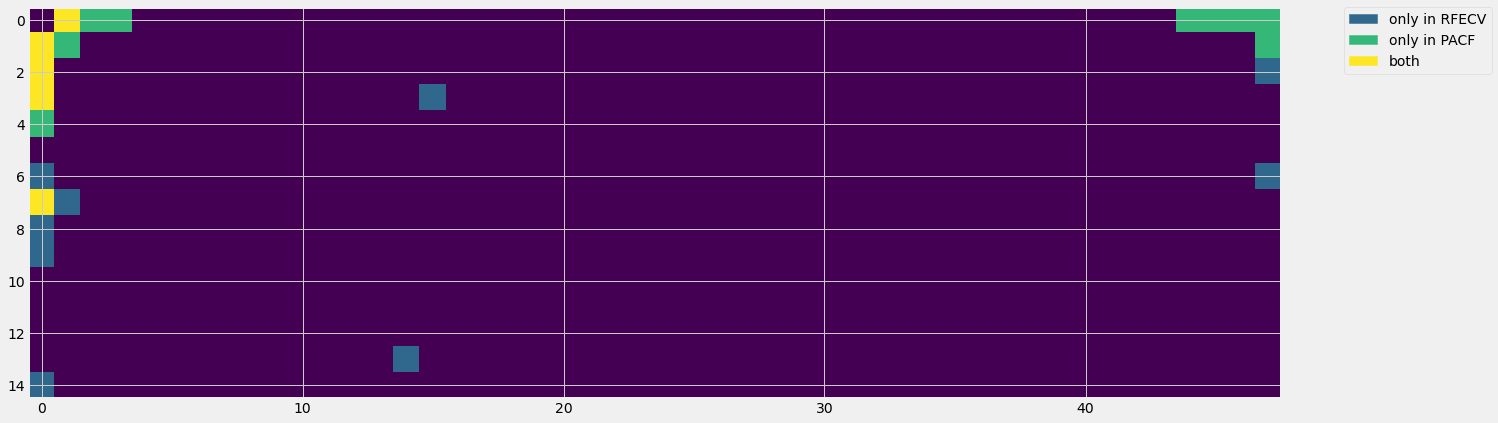

Train R2 scores: 0.49935356956717525, 0.4858271770864523, 0.4852821243887766, 0.49135878427510526, 0.49812373195195303
Test  R2 scores: 0.45897744165502696, 0.5114642738558266, 0.5160745814237533, 0.48354480324787064, 0.4614888062150112
Mean absolute error: train 0.32, test 0.30
Mean squared error:  train 0.21, test 0.18
Explained Variance Score (best=1): train 0.49, test 0.52
Coefficient of determination (R2): train 0.49, test 0.52
Adjusted coeff. of determination:  train 0.48, test 0.51
AIC: train 18.62, test 21.73


In [15]:
run_cell=False

n_days=15

def scorer_adj_r2(estimator, X, y):
    n = X.shape[0]
    p = X.shape[1]
    y_pred = estimator.predict(X)
    R2 = r2_score(y, y_pred)
    return 1-(1-R2)*(n-1)/(n-p-1)

if run_cell:
    # construct dataset
    feat_cols = ['hourofd_x', 'hourofd_y', 'dayofy_x', 'dayofy_y', 'temperature_hourly'] 
    filt_days = ['Thursday']
    replacement_method='day_before'
    df_reg, X, y, feat_names = construct_dataset(df_1p,
                                             feat_cols=feat_cols,
                                             filt_days=filt_days,
                                             remove_holiday=True,
                                             lags = np.arange(1,n_days*48),
                                             replacement_method=replacement_method)
    # add constant column
    X_ext = sm.add_constant(X)
    feat_names = ['constant'] + feat_names

    # set up rfecv
    min_features_to_select=1
    rfecv = RFECV(estimator=SMWrapper(sm.OLS, fit_intercept=False), step=1, cv=5,
                  scoring=scorer_adj_r2,
                  min_features_to_select=min_features_to_select)
    rfecv.fit(X_ext, y)
    
    # selected features
    feat_rfecv = [feat_names[i] for i, x in enumerate(rfecv.support_) if x]

    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(min_features_to_select,
                   len(rfecv.grid_scores_) + min_features_to_select),
             rfecv.grid_scores_)
    plt.show()
    
    # save model
    #ols_obj_rfecv = rfecv.estimator_
    #filehandler = open('ols_obj_rfecv.txt', 'wb') 
    #pickle.dump(ols_obj_rfecv, filehandler)
    
else:
    # plot
    fig, axs = plt.subplots(figsize=(8,8))
    img = mpimg.imread('rfecv.png')
    imgplot = plt.imshow(img)
    plt.show()

    feat_rfecv = ['constant', 'hourofd_y', 'temperature_hourly', 
     'lag 1', 'lag 48', 'lag 96', 'lag 143', 'lag 144', 
     'lag 159', 'lag 288', 'lag 335', 'lag 336', 'lag 337', 
     'lag 384', 'lag 432', 'lag 638', 'lag 672']
    # load model
    #file_pi2 = open('ols_obj_rfecv.txt', 'rb') 
    #ols_obj_rfecv = pickle.load(file_pi2)
     

# display results
print("\nRecurssive Feature Elimination + CV")
print("Optimal number of features: %d" % len(feat_rfecv))
print("Selected features:")
print(feat_rfecv)

# divide 
lag_rfecv = np.array([int(x.replace('lag ',''))  for x in feat_rfecv if x.startswith('lag ')])
feat_col_rfecv = [x for x in feat_rfecv if not x.startswith('lag ') and not x=='constant']

# compare with high corr
feat_mat = np.zeros((n_days,48))
for f in lag_rfecv:
    feat_mat[math.floor(f/48)][f%48] = 1
for f in lags:
    feat_mat[math.floor(f/48)][f%48] = feat_mat[math.floor(f/48)][f%48]+2

plt.figure(figsize=(20,10))
im = plt.imshow(feat_mat, interpolation='none')

# get the colors of the values, according to the 
# colormap used by imshow
colors = [ im.cmap(im.norm(value)) for value in np.arange(1,4)]
labels = ['only in RFECV', 'only in PACF', 'both']
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label=labels[i]) for i in np.arange(3) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.grid(True)
plt.show()

# error measures
df_rfecv, X_rfecv, y_rfecv, feat_names_rfecv = construct_dataset(df_1p,
                                         feat_cols=feat_col_rfecv,
                                         filt_days = filt_days,
                                         remove_holiday=True,
                                         lags = lag_rfecv,
                                         replacement_method=replacement_method)
ols_obj_rfecv = SMWrapper(sm.OLS).cv_fit(X_rfecv, y_rfecv)
meas_rfecv = error_measures(ols_obj_rfecv, X=X_rfecv, y=y_rfecv, verbose=True)

**2.3 Comapring Feature Selection Methods**
* APCF selects features that are more intuitive: only around the same hour, recent days
* MSE and adj. R2 of both methods are close, RFECV is slightly better
* RFECV selects fewer number of features
* PACF uses the whole time-series (all days) to ranks features 
* RFECV can be easily performed on differnt parts of the time-series, e.g. different days, different parts of the day, ...

# 3 Visualizing Predictions
Goal: Produce plots to evaluate the performance of the linear model


**3.1 Residual plots:**
Plot residual (predicted-actual) vs. predicted


Ideal:
* Points are symmetrically distributed
* Points are clustered near the y-axis
* No clear patterns

Observations:
* (-) Cone-shaped plots, error variance increases with consumption 
* (-) Error magnitude is large w.r.t predicted value; e.g., residual of 1 at noon when consumption is around 1 => 100% error

Interpretation:
* If cone-shaped, data is heteroscedastic (i.e. the variance of the errors is not constant)


Consequences of heteroscedasticity:
* OLS will not give you the estimator with the smallest variance (i.e. your estimators will not be useful).
* Significance tests will run either too high or too low.
* Standard errors will be biased, along with their corresponding test statistics and confidence intervals.

ref: https://www.qualtrics.com/support/stats-iq/analyses/regression-guides/interpreting-residual-plots-improve-regression/

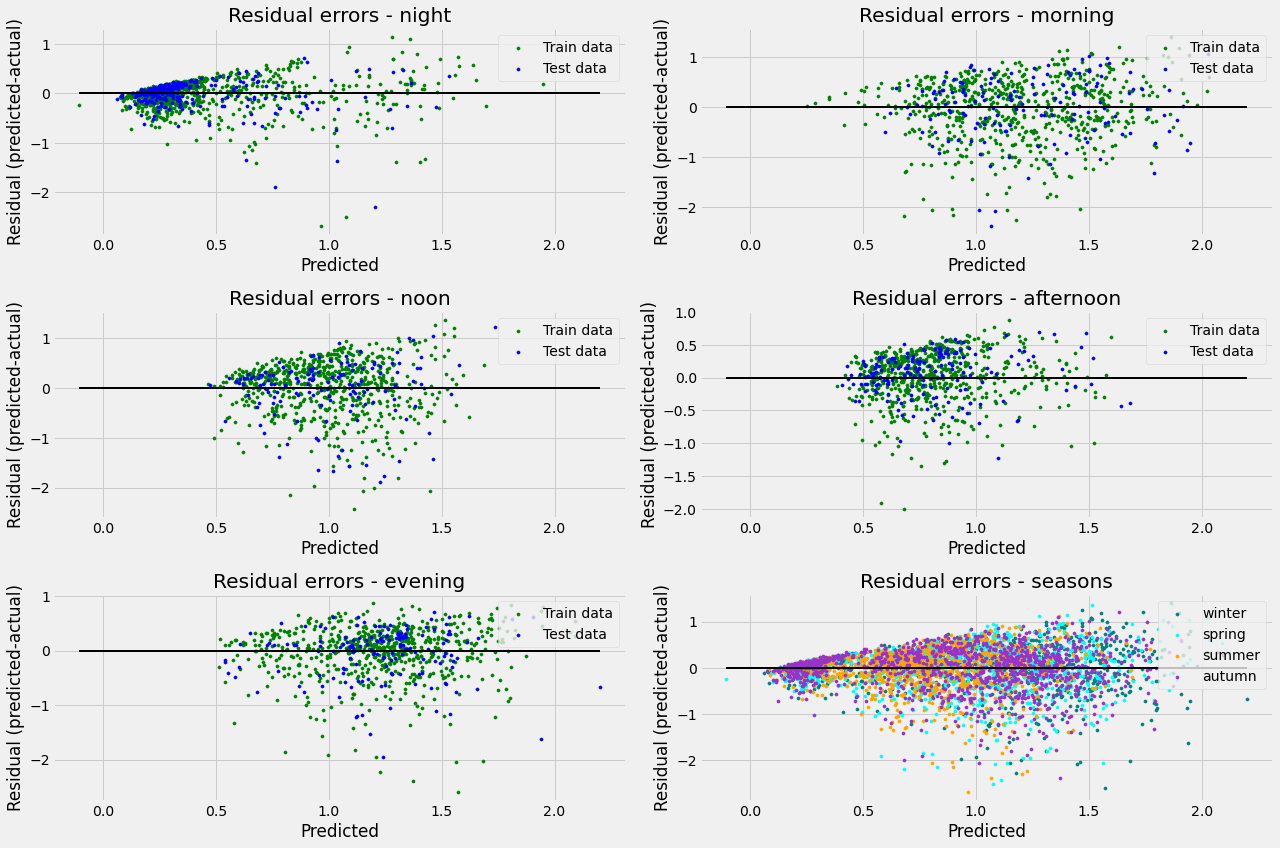

In [9]:
#residuals_plot(df_reg_hc, ols_obj_hc, feat_names_hc, on_x_axis = 'pred')
residuals_plot(df_rfecv, ols_obj_rfecv, feat_names_rfecv, on_x_axis = 'pred')

**3.2 Predictions in different months**

Observations:
* (+) The general trend is captured
* (+) Residuals show no clear trend with time
* (-) Consumption peaks were poorly modeled that results in considerable peaks in residuals
* No clear distinction between model performance in different months

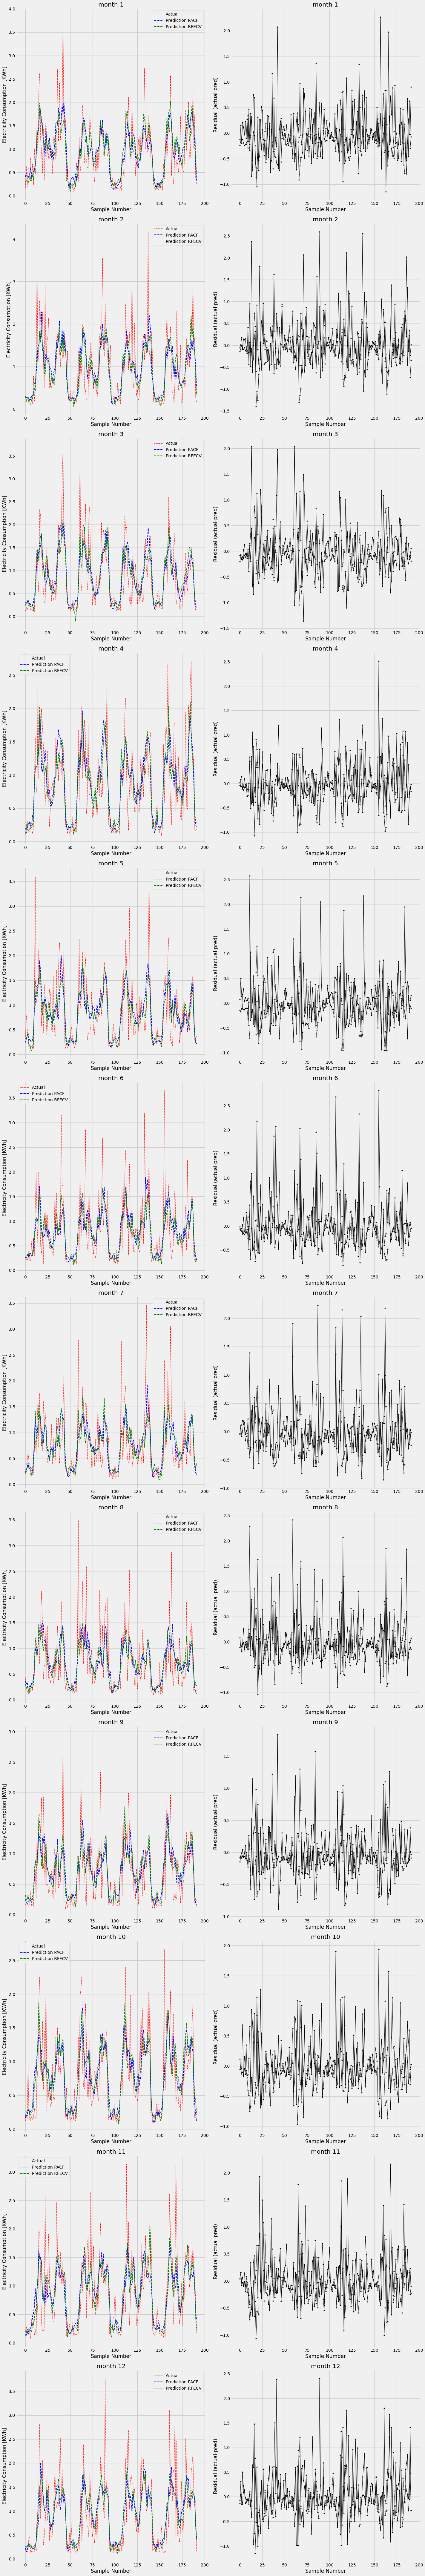

In [10]:
monthly_plots(ols_obj_hc, X_hc, y_hc, 
              ols_obj_rfecv, X_rfecv, y_rfecv)

**3.3 Actual vs. Prediction**

Observations:
* Performance is different over morning/noon/...
* No clear distinction between seasons
* (-) Over-predicting at high consumptions
* (-) Under-predicting at low consumptions

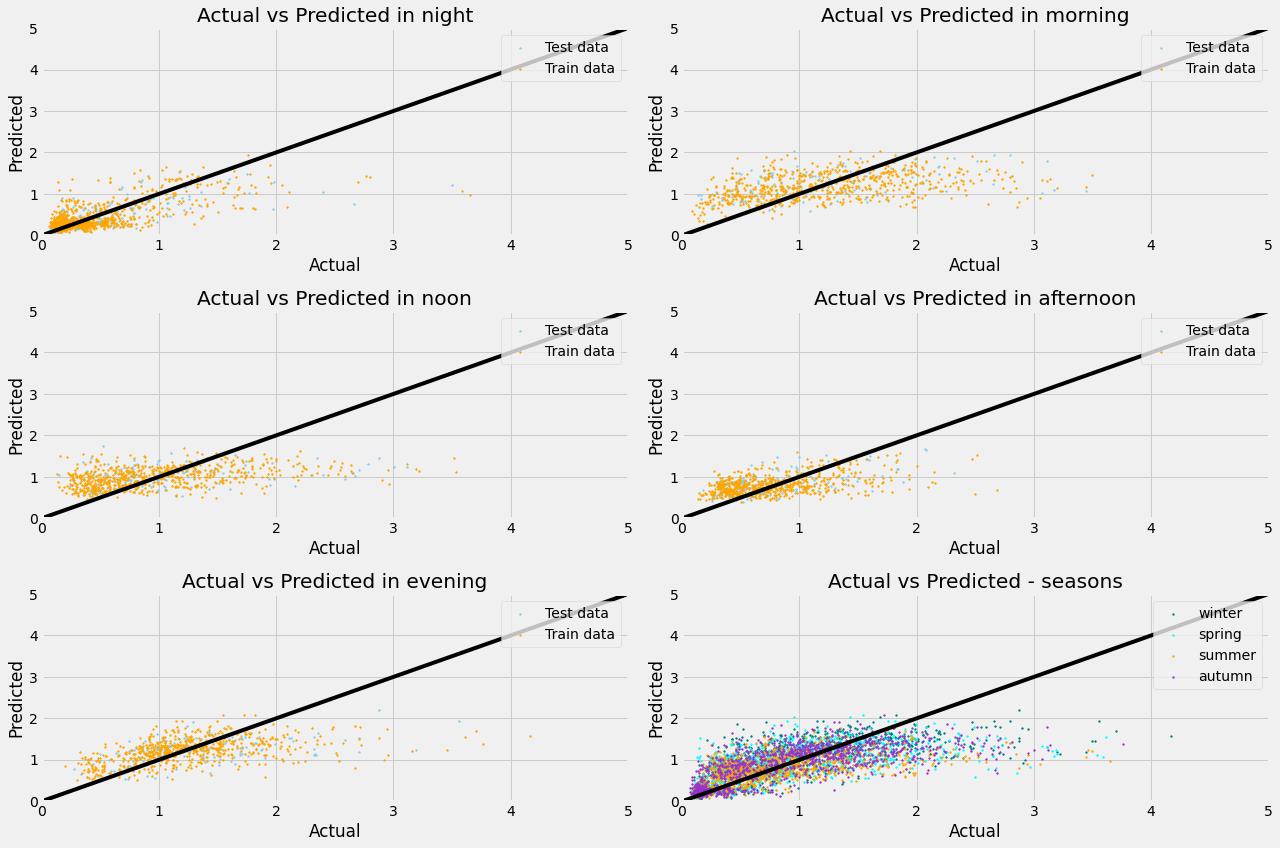

In [11]:
#plot_actual_prediction(df_reg_hc, ols_obj_hc, feat_names_hc)
plot_actual_prediction(df_rfecv, ols_obj_rfecv, feat_names_rfecv)

# 4 Statistical Analysis of Ordinary Least Squares with statsmodels.api
**4.0 Theory:**
* Ordinary Least Squares model   
* trained k=5 times, each round using (k-1)/k samples as the training dataset
* adjusted R2 criterion is calculated on the other 1/k of the data (validation dataset)
* the model with the highest adj. R2 on validation dataset is returned

Evaluation measures:
* R-squared: proportion of variation in the outcome explained by regressors (the same as the squared correlation between actual and predicted values for OLS)
* Adj. R-squared: adjusted with the number of features, adjusted R-squared is equal to 1 - (n-1)/(n–k-1)*(1-R2)
* F-statistic: whether a complex model is better than a simpler version of the same model in explaining the variance in the dependent variable  
* Prob (F-statistic): t-test for how large F is               
* Log-Likelihood:                
* AIC: in general, AIC=2*num_of_regressors-2*log(likelihood). For linear regression, use log(sum of squared errors) instead of log(likelihood). Smaller AIC is preferred.                            
* BIC:   


Interpreting the coefficients:
* std err: estimate of the standard deviation of the coefficient, the amount it varies across cases          
* t: coefficient divided by its standard error. If a coefficient is large compared to its standard error, then it is probably different from 0.      
* P>|t|



More statistics:
* Omnibus & Skew: a test of the skewness of the residual, ideally 0 => errors are Gaussian => linear regression approach would probably be better than random guessing but likely not as good as a nonlinear

* Prob Omnibus: statistical test indicating the probability that the residuals are normally distributed,ideally 1

* Kurtosis: a measure of "peakiness", greater Kurtosis can be interpreted as a tighter clustering of residuals around zero, implying a better model with few outliers

* Durbin-Watson: tests for homoscedasticity, ideal value between 1 and 2

* Jarque-Bera (JB)/Prob(JB): like the Omnibus test in that it tests both skew and kurtosis

* Condition Number: sensitivity of a function's output as compared to its input. When we have multicollinearity, we can expect much higher fluctuations to small changes in the data, hence, we hope to see a relatively small number, something below 30. 

Ref: https://www.accelebrate.com/blog/interpreting-results-from-linear-regression-is-the-data-appropriate


Package: https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.html


In [12]:
print(ols_obj_hc.summary(xname=['constant']+feat_names_hc))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     175.9
Date:                Thu, 22 Apr 2021   Prob (F-statistic):               0.00
Time:                        07:47:03   Log-Likelihood:                -2501.0
No. Observations:                3879   AIC:                             5042.
Df Residuals:                    3859   BIC:                             5167.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
constant               0.1796      0

**Significance of regressors:**

Above results show that all features weren't significant. We remove these features and train another model on the reduced features set.

Result: AIC improves but other measures do not change significantly.

In [13]:
# Create linear regression object
ols_obj_hc_sig, X_sig, _ = remove_nonsig(ols_obj_hc, feat_names_hc, df_1p, filt_days, replacement_method)
meas_hc_sig = error_measures(ols_obj_hc_sig, X_sig, y, verbose=True)

Significant regressors:
['constant', 'hourofd_x', 'hourofd_y', 'dayofy_y', 'temperature_hourly', 'lag 1', 'lag 2', 'lag 3', 'lag 46', 'lag 47', 'lag 48', 'lag 49', 'lag 95', 'lag 96', 'lag 144', 'lag 192', 'lag 336']
Removed regressors:
['dayofy_x' 'lag 44' 'lag 45']
Mean absolute error: train 0.33, test 0.32
Mean squared error:  train 0.21, test 0.21
Explained Variance Score (best=1): train 0.46, test 0.50
Coefficient of determination (R2): train 0.46, test 0.50
Adjusted coeff. of determination:  train 0.46, test 0.49
AIC: train 18.55, test 21.41


# 5 Summary
**Overview:**
* Goal: 1-step ahead consumption prediction in 30 min intervals
* Scope: single household
* Regressors: temperature, time of the day, day of the year, auto-regressors with different lags
* Methodology: linear regression 


**What has been done so far:**
* Data cleaning
* Feature selection with RFECV and PACF+CV methods
* Significance analysis
* Visulaization

**Results:**
* The general trend can be modeled 
* Sudden high peaks are underestimated
* Both feature selection methods obtain similar error measures
* The number of selected features is less than 20
* Important features are among 48k +/- 2, k between 0 and 7

**To do next:**
Improving the fit
* Are outliers the only source of error?
* 1 hour resolution
* Modeling the residuals

Robustenss analysis:
* Effect of weekday
* Effect of time of the day
* Comparing error between different households

Federation:
* Is this problem a good instance for federated learning?

# Short Code: Fit Linear Regression Model

In [17]:
# set training data
household.train_test_split(test_frac=0.25)
# LR
method='Adam'
lr = 0.1
household.fit_personal_model(method=method, lr=lr, iterations=100)
res = household.evaluate_model(method=method, 
                               measures=['MSE', 'MAE', 'R2', 'Adjr2', 'AIC'], 
                               verbose=True)

Mean squared error:  train 0.19, test 0.20
Mean absolute error: train 0.30, test 0.32
Coefficient of determination (R2): train 0.49, test 0.44
Adjusted coeff. of determination:  train 0.48, test 0.44
AIC: train 60.75, test 62.82


In [ ]:
#jupyter nbconvert --to html --TemplateExporter.exclude_input=True Lin_Reg_Part1.ipynb